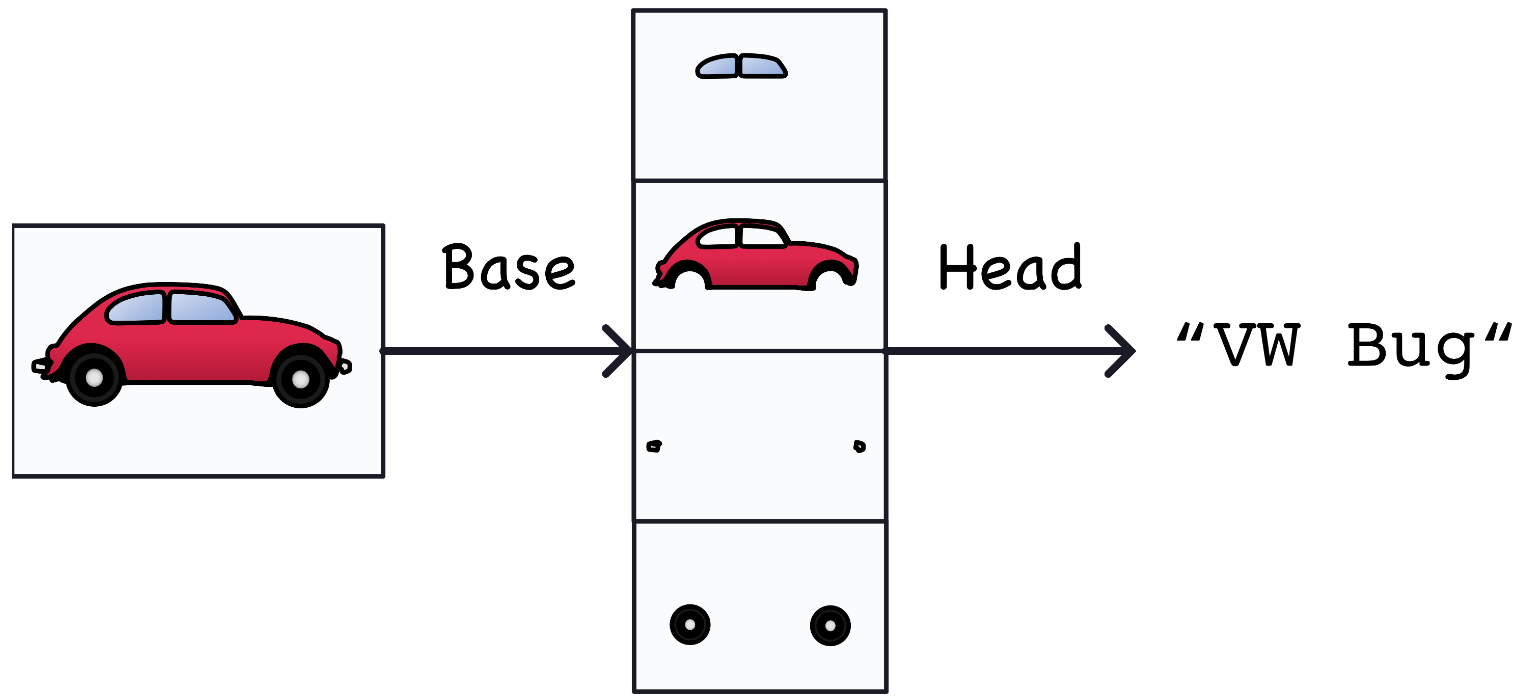

**Transfer learning** - is so effective, that almost every image classifier these days will make use of it.

## Step 1 - Load Data

In [1]:
# Import libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# Reproducability
def set_seed(seed=27):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(27)

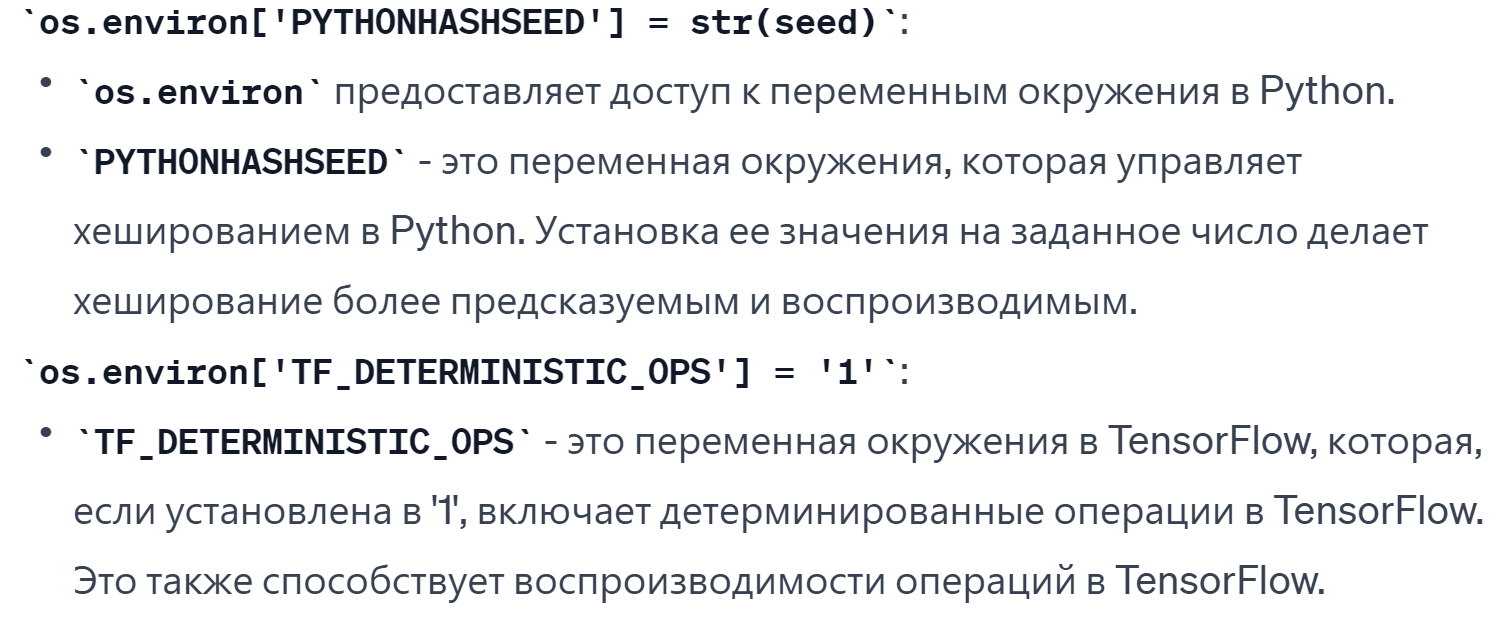

In [3]:
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

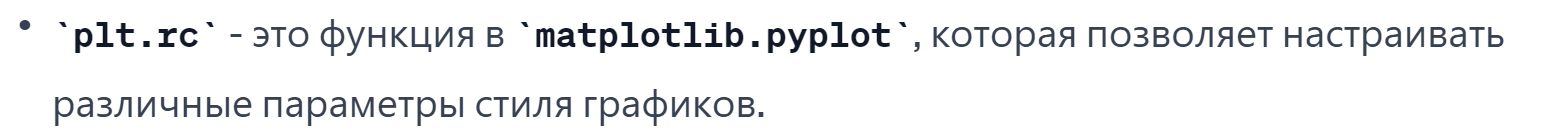
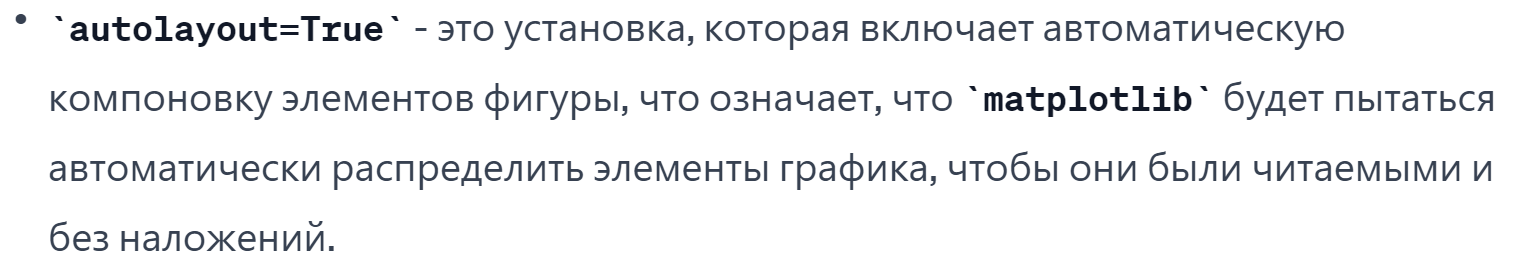
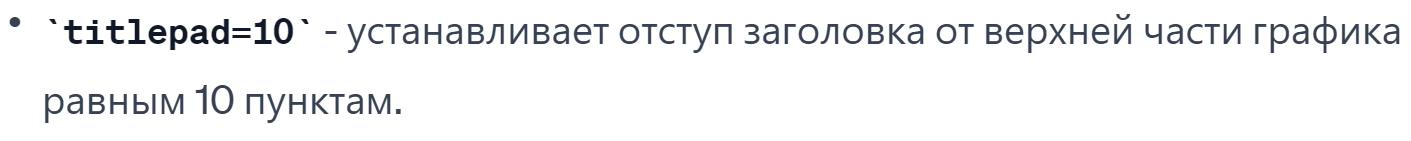

In [4]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True
)

ds_valid_ = image_dataset_from_directory(
    'valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


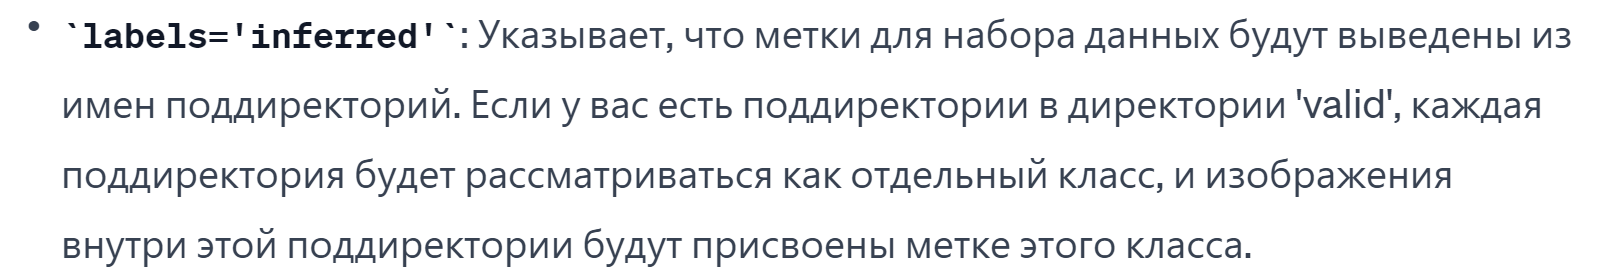
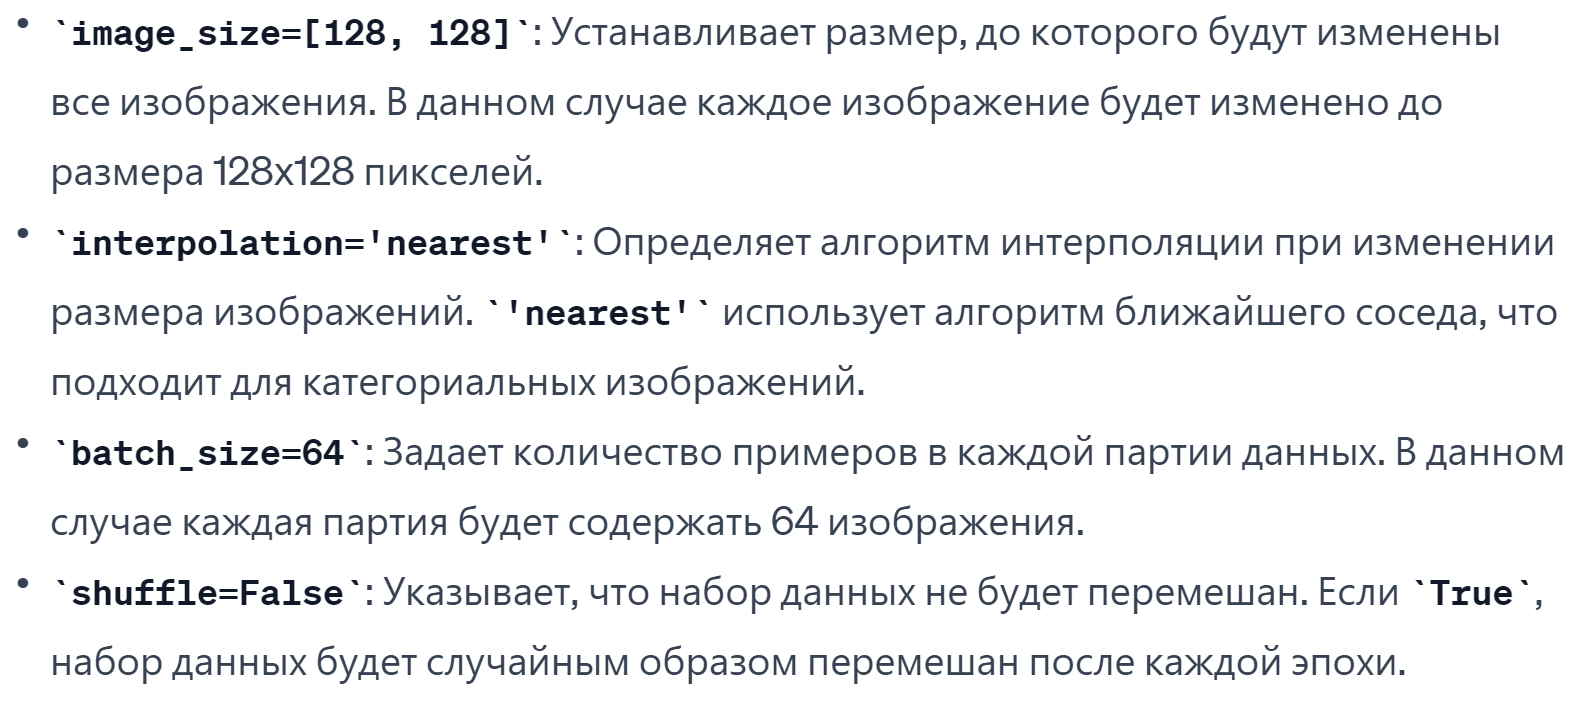

In [5]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label


AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

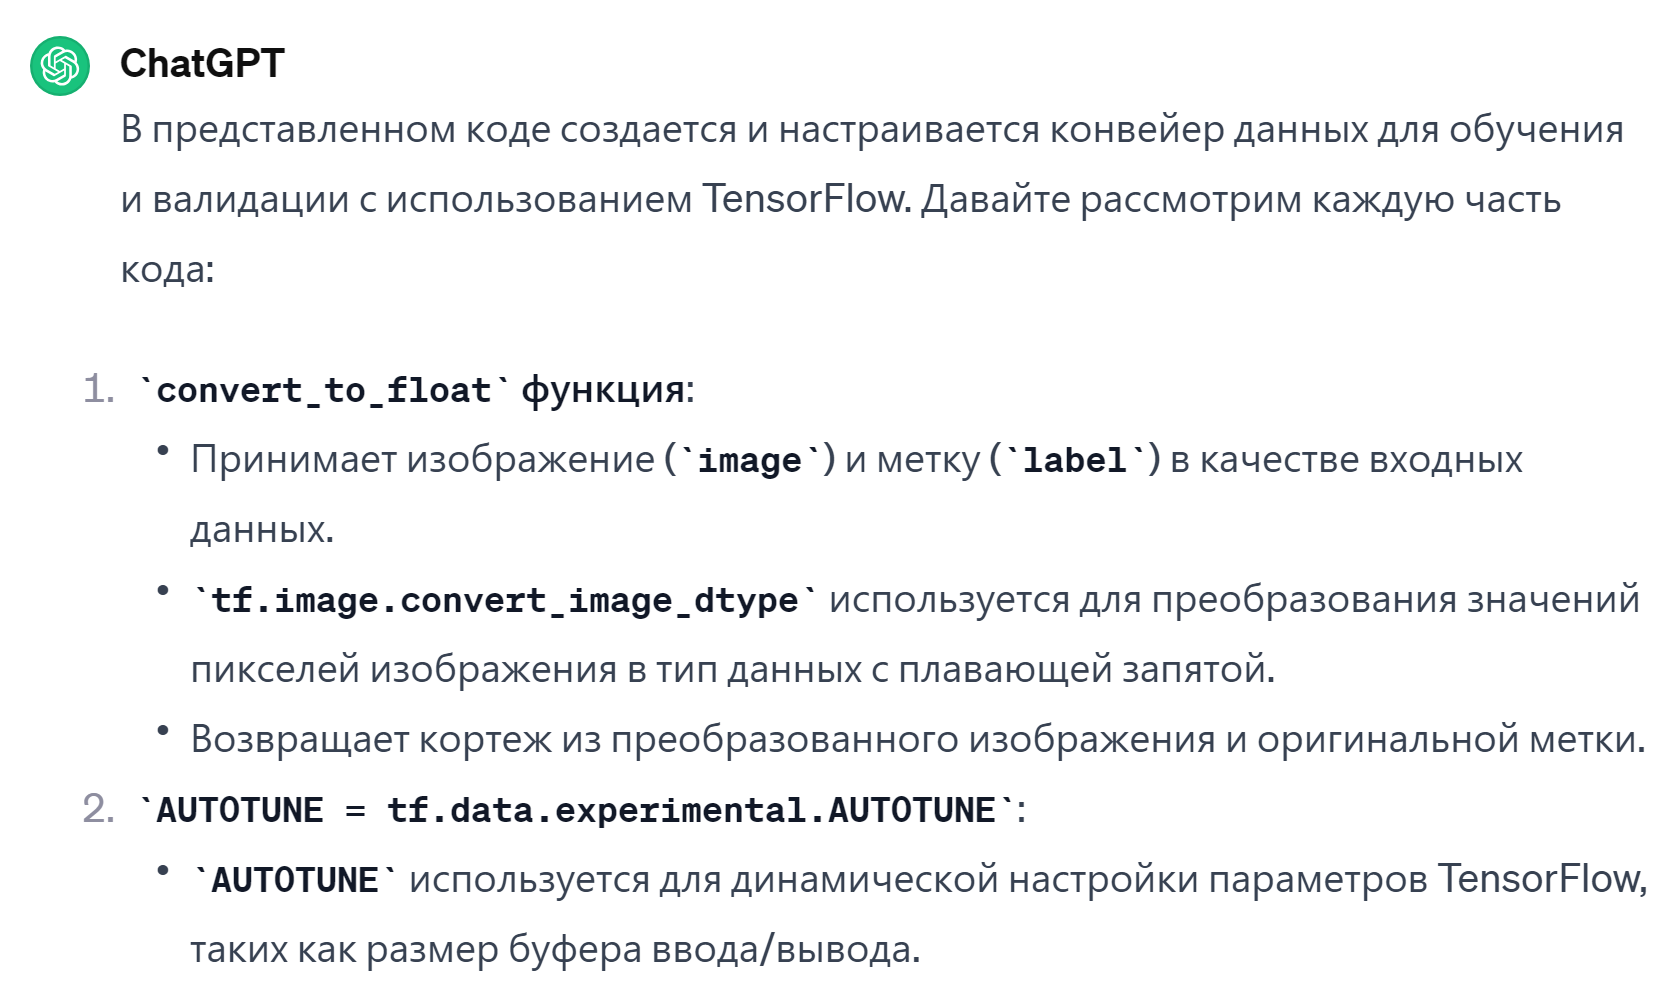
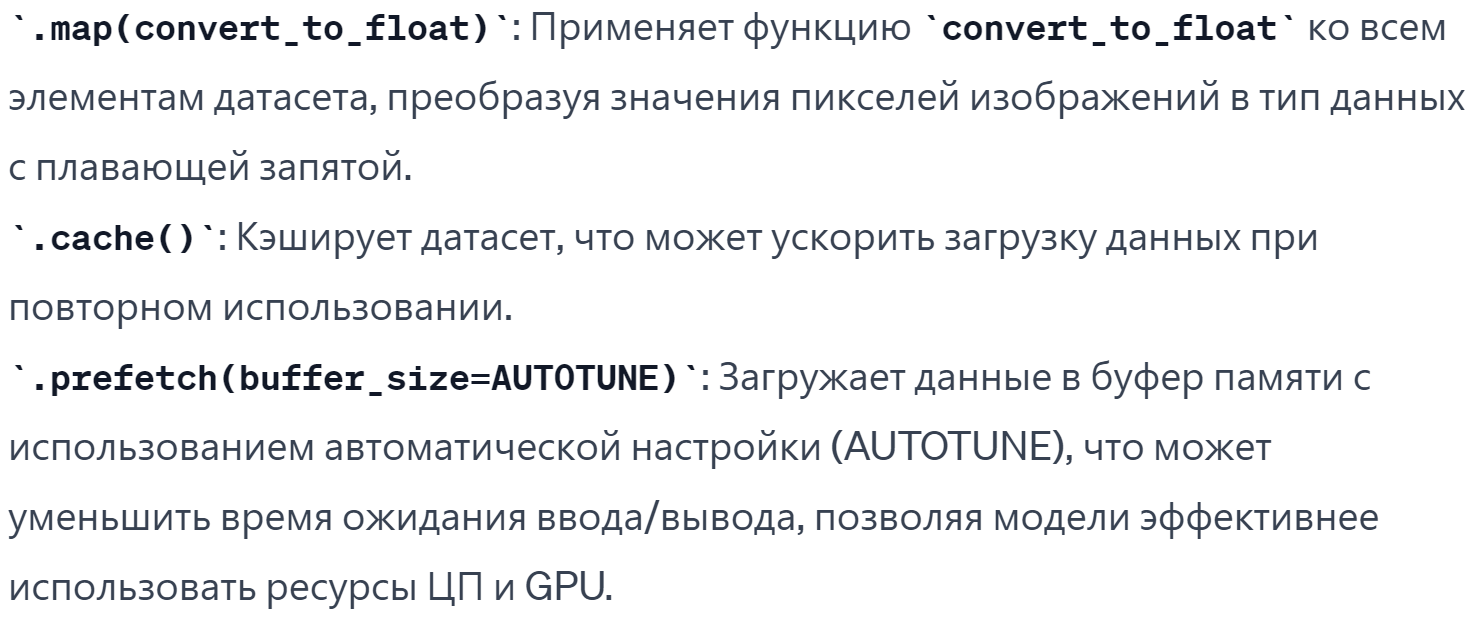

## Step 2 - Define Pretrained Base

In [6]:
pretrained_base = tf.keras.models.load_model('cv-course-models/vgg16-pretrained-base')
pretrained_base.trainable = False

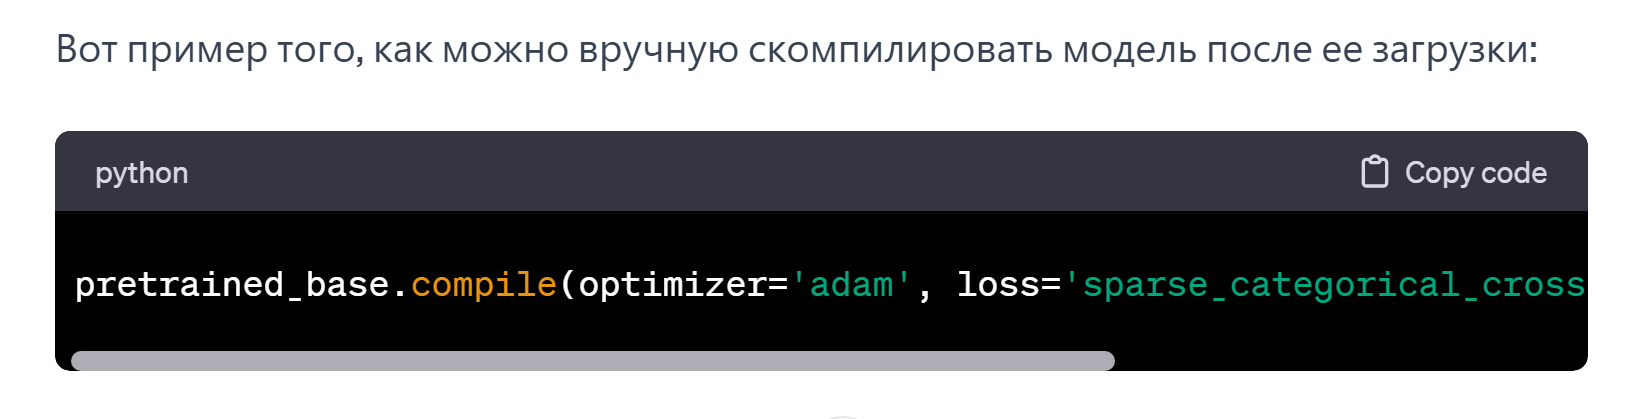

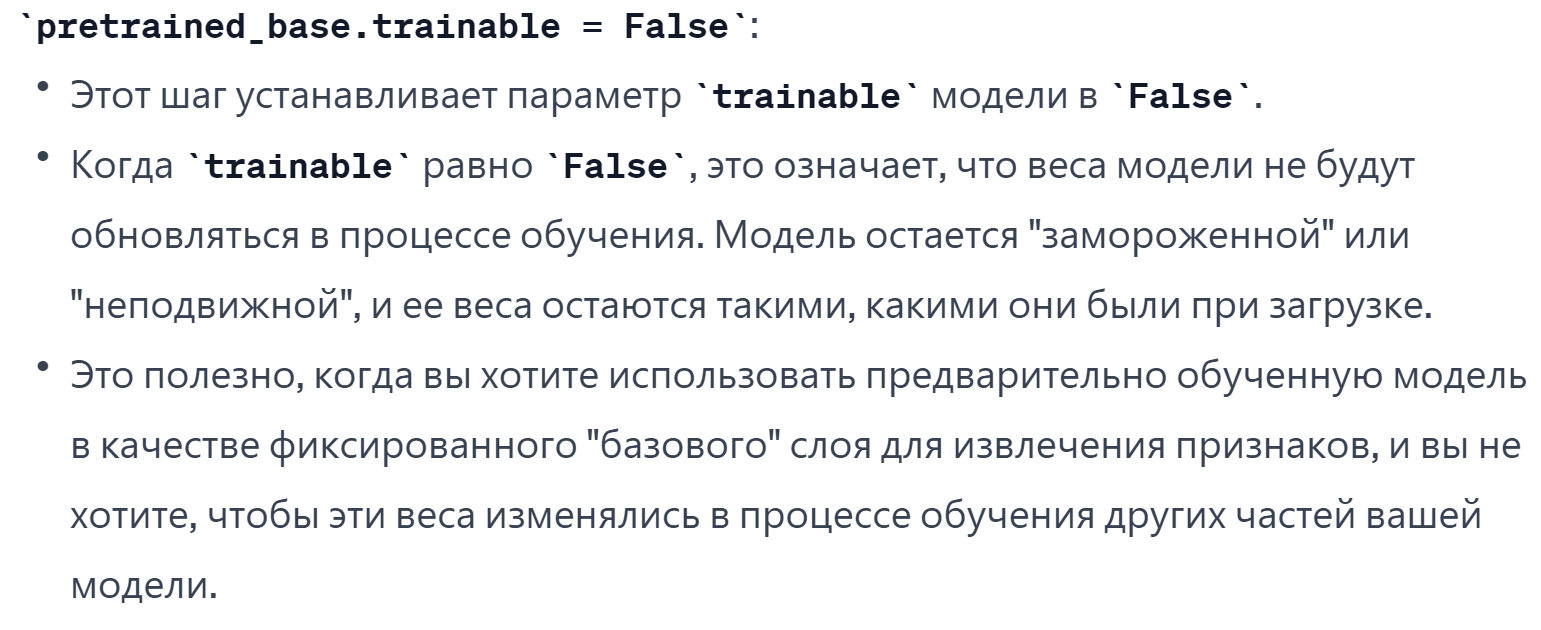

## Step 3 - Attach Head

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,  # First layers are pretrained from another architecture
    layers.Flatten(),
    layers.Dense(units=6, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])

## Step 4 - Train

In [8]:
# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=['binary_accuracy']
# )

# history = model.fit(
#     ds_train,
#     validation_data=ds_valid,
#     epochs=30,  # 100 if there would be GPU
#     verbose=1
# )

In [9]:
# Visualize train process
# history_frame = pd.DataFrame(history.history)
# history_frame.loc[:, ['loss', 'val_loss']].plot()
# history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

# Convolution and ReLU

Filter an image for a particular feature (convolution)

Detect that feature within the filtered image (ReLU)

Condense the image to enhance the features (maximum pooling)

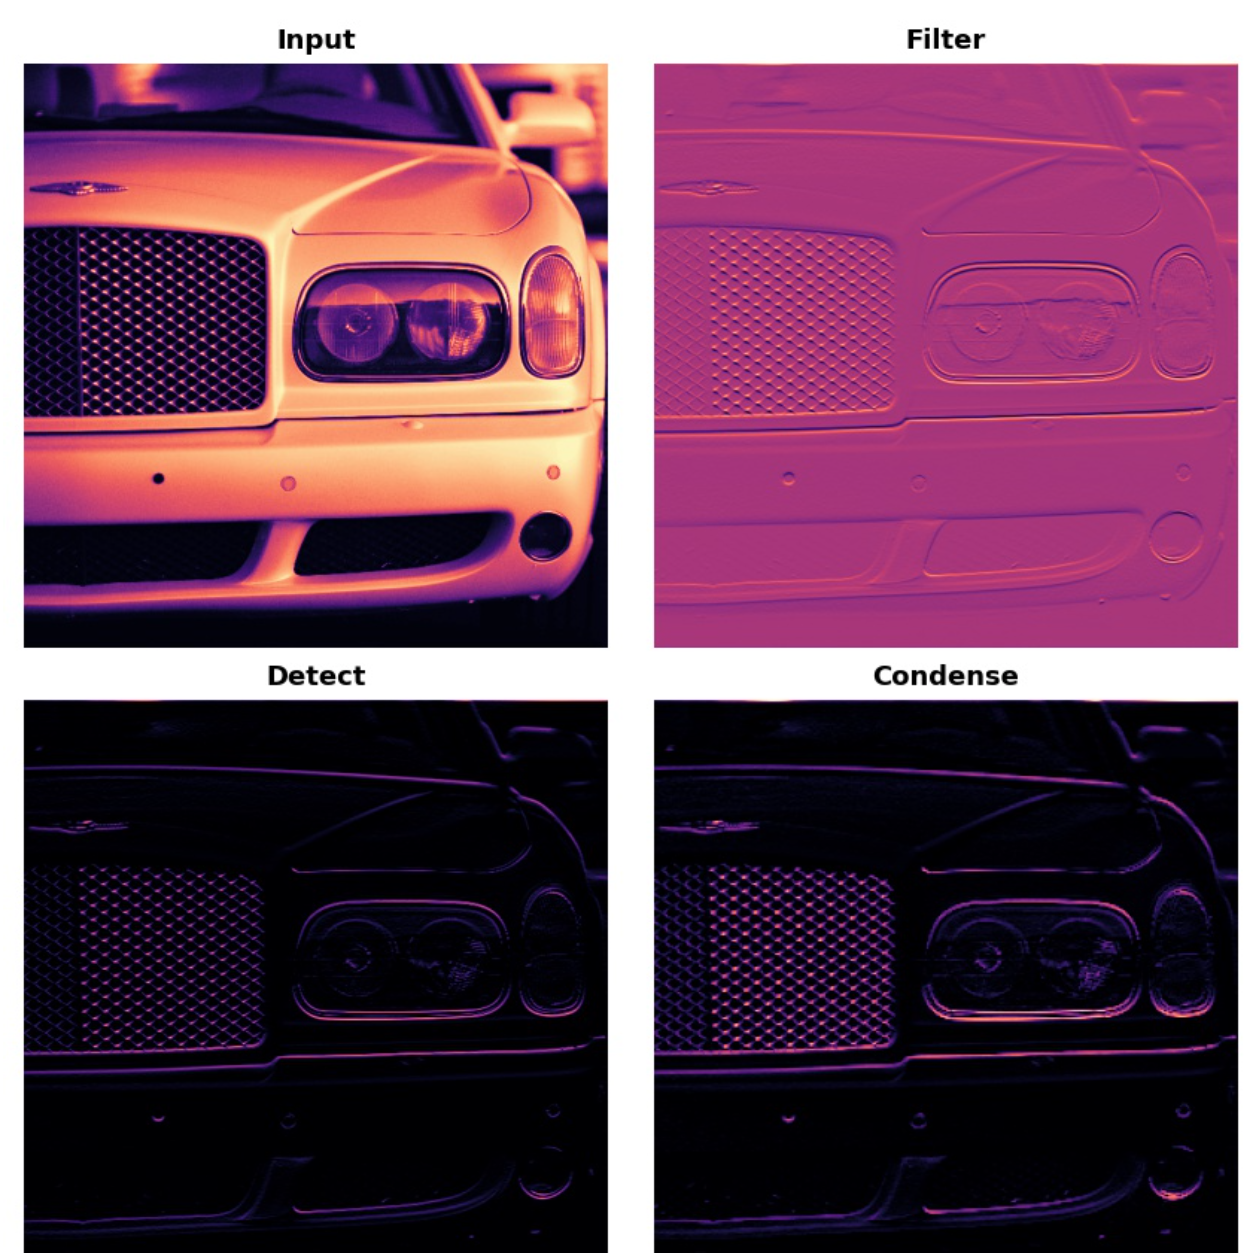

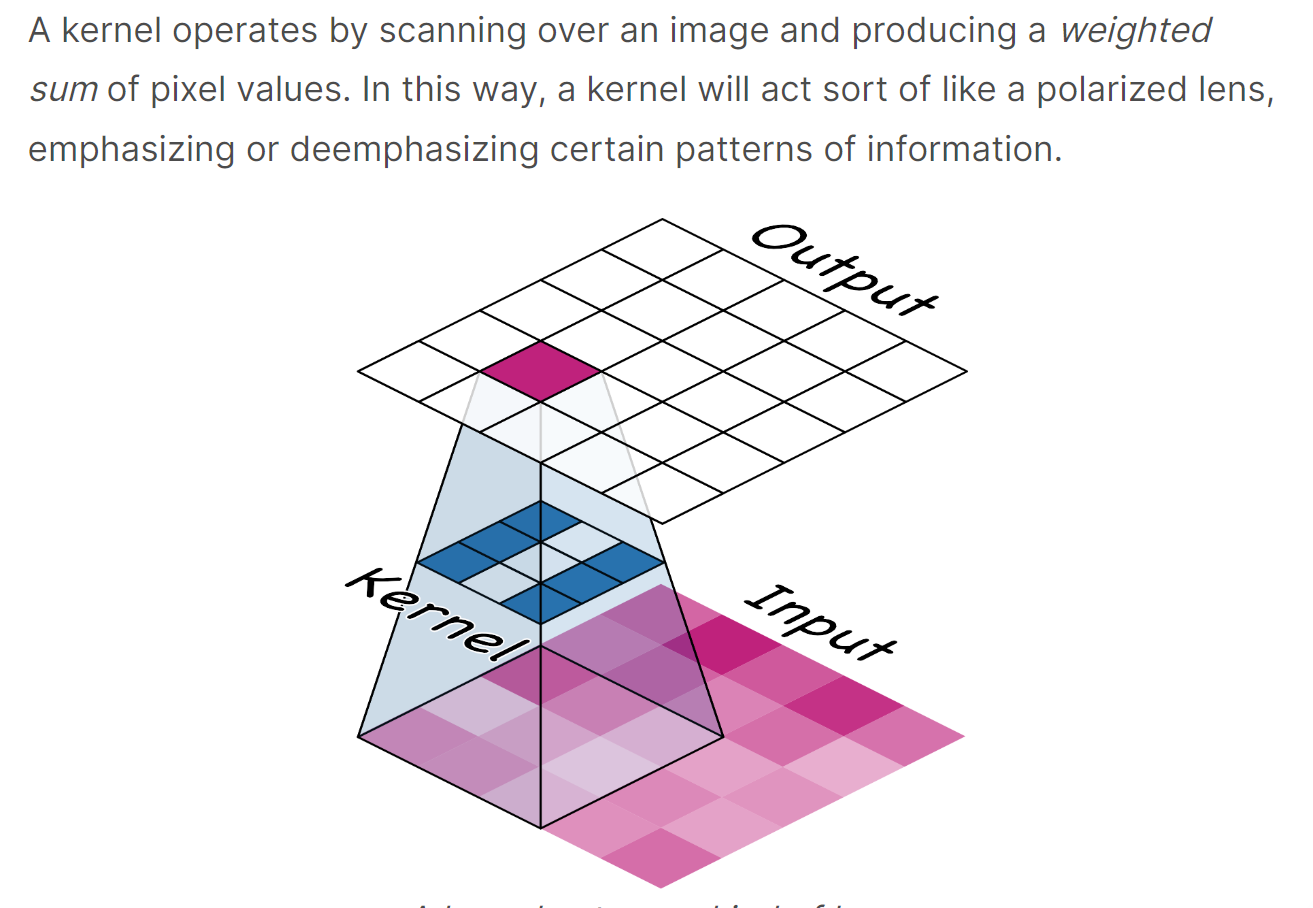

Как и другие функции активации, функция ReLU нелинейна. По сути, это означает, что общий эффект всех слоев в сети становится отличным от того, который вы могли бы получить, просто сложив эффекты вместе, что было бы таким же, как то, чего вы могли бы достичь, используя только один слой.
Нелинейность гарантирует, что функции будут интересным образом комбинироваться по мере их продвижения в сеть.

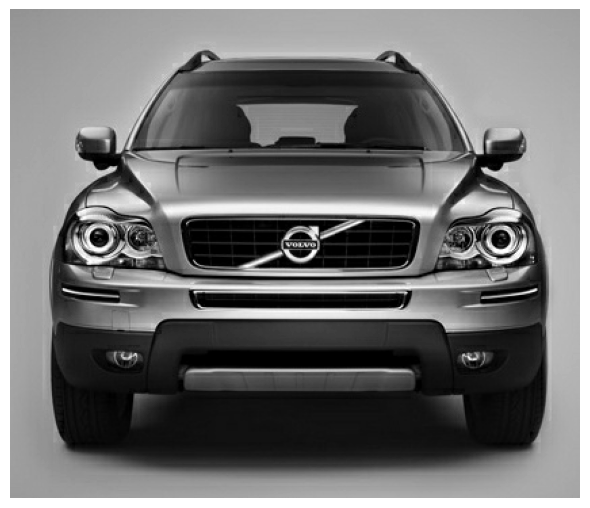

In [10]:
image_path = 'car_feature.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show();

In [11]:
# Reformat for batch compatibility
kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

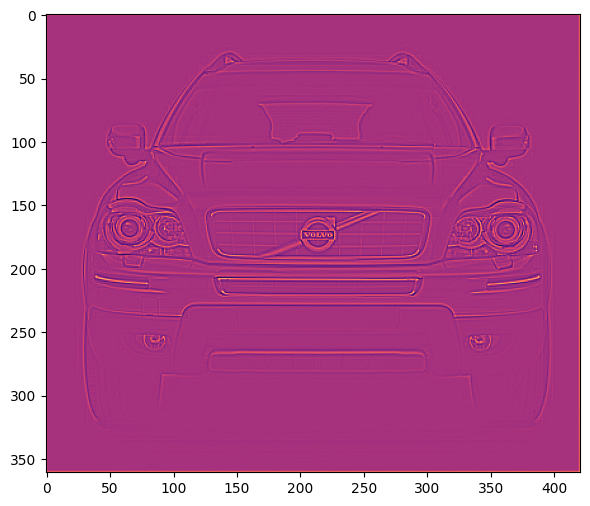

In [12]:
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='SAME'
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_filter))
plt.axis=('off')
plt.show();

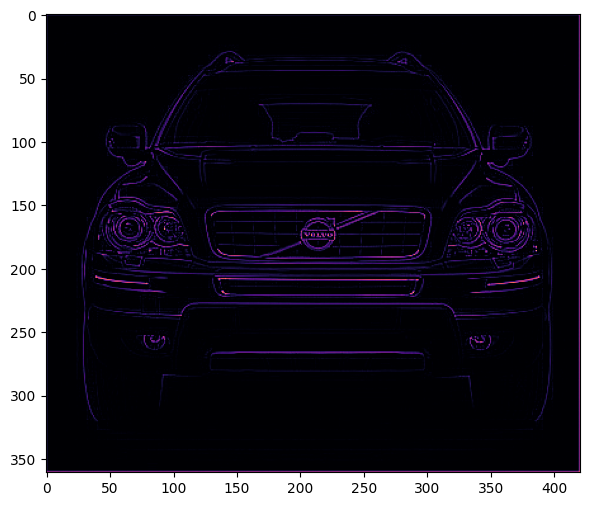

In [13]:
image_detect = tf.nn.relu(image_filter)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_detect))
plt.axis=('off')
plt.show();

# Maximum pooling

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3),  # activation is None
    layers.MaxPool2D(pool_size=2)
    # More layers follw
])

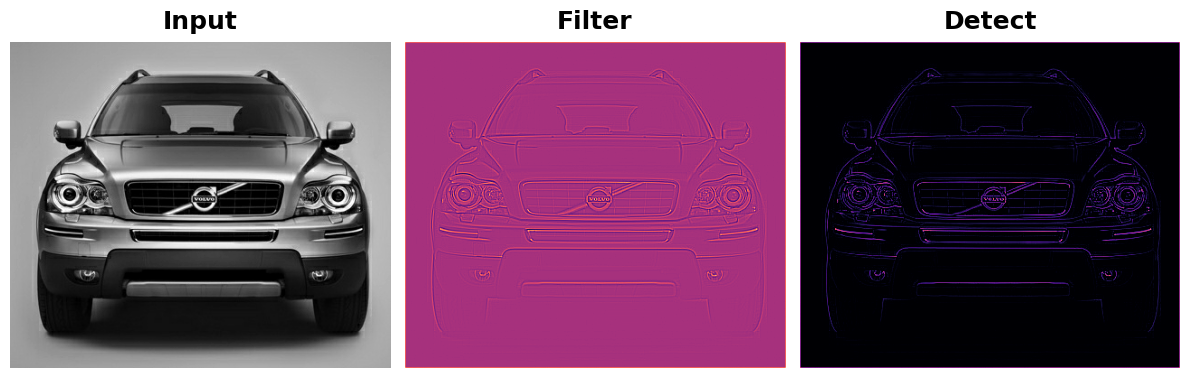

In [15]:
# Detect step
image_detect = tf.nn.relu(image_filter)

# Show what we have so far
plt.figure(figsize=(12, 6))

# Input
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.title('Input')

# Filter
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.title('Filter')

# Detect
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.title('Detect')


for ax in plt.gcf().get_axes():
    ax.set_axis_off()

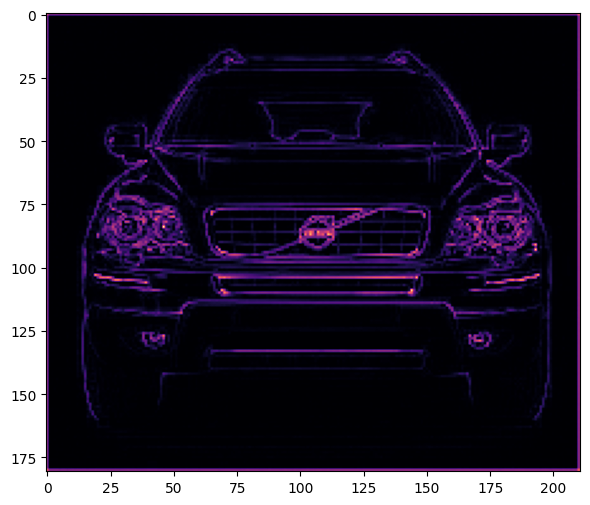

In [16]:
# Pooling
import tensorflow as tf

image_condense = tf.nn.pool(
    input=image_detect,  
    window_shape=(2, 2),
    pooling_type='MAX',
    strides=(2, 2),
    padding='SAME'
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_condense))
plt.show();

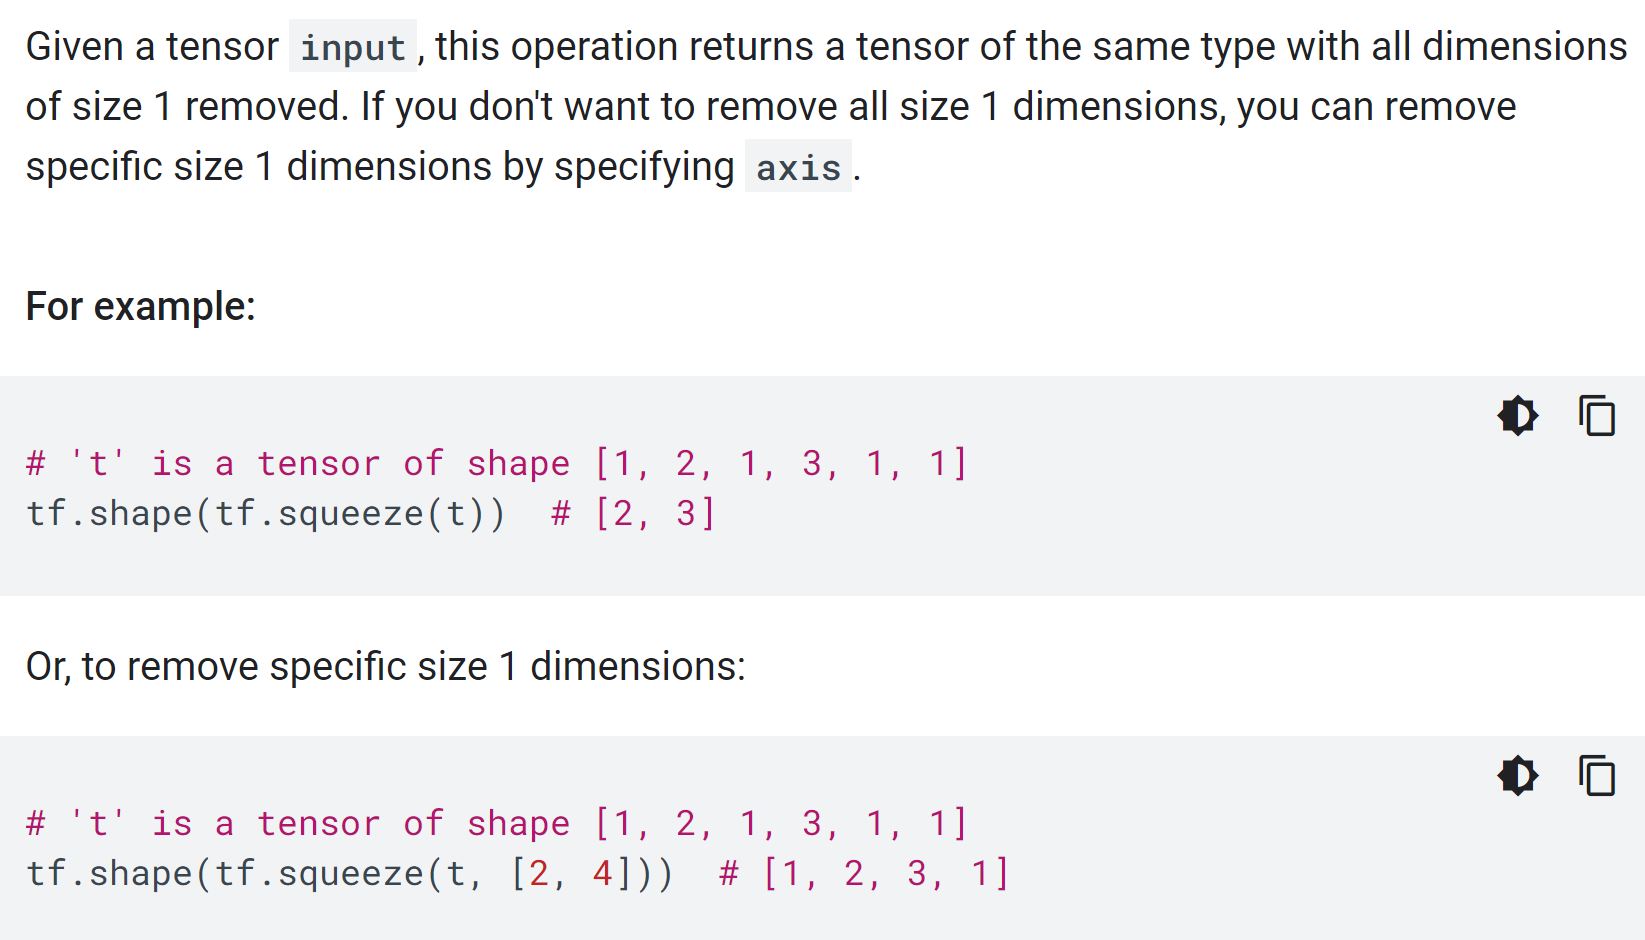

### [matplotlib.pyplot.get_cmap](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.get_cmap.html)

# Stride and Padding

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  activation='relu'),
    layers.MaxPool2D(pool_size=2,
                     strides=1,
                     padding='same')
    # More layers follow
])

# Custom Convnets

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=32, 
                  kernel_size=5, 
                  activation='relu', 
                  padding='same', 
                  input_shape=(128, 128, 3)
    ),
    layers.MaxPool2D(),
    layers.Conv2D(filters=64, 
                  kernel_size=3, 
                  activation='relu',
                  padding='same'
    ),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(units=6, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_2 (Dense)             (None, 6)                

In [19]:
# Train process
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# history = model.fit(
#     ds_train,
#     validation_data=ds_valid,
#     epochs=40,
#     verbose=1
# )

# Data Augmentation

In [20]:
from tensorflow.keras.layers.experimental import preprocessing

model = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomContrast(0.5),
    # Base
    pretrained_base,
    # Head
    layers.Flatten(),
    layers.Dense(units=6, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')    
])

In [21]:
# Train and compile
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# history = model.fit(
#     ds_train,
#     validation_data=ds_valid,
#     epochs=30,
#     verbose=1 
# )

In [22]:
# history_frame = pd.DataFrame(history.history)

# history_frame.loc[:, ['loss', 'val_loss']].plot()
# history_farme.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();